# Aereal data to hex

This notebook __creates tables 'hex_aereal_res{res}.gpkg'__, used in notebooks that calculate HQSL and notebook aux17.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [2]:
# 'alex' or 'edgar'
all_local_dirs = 'alex'
# Output hexs resolution
res = 10
# save output to local?
save = True

In [3]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/processed/santiago/areal_data/"
    count_pois_dir = "../../../data/external/temporal_fromjupyter/santiago/pois/"
    ndvi_dir = "../../../data/external/temporal_todocker/santiago/ndvi_santiago/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/00_pois_formated/areal_data/"
    count_pois_dir = grl_dir
    ndvi_dir = grl_dir
else:
    print("WARNING: Fix all_local_dirs variable")

## Create hexgrid from area of interest

In [4]:
query = 'SELECT * FROM projects_research.santiago_aoi'
aoi = aup.gdf_from_query(query)

# When working without internet connection:
#aoi = gpd.read_file("../../../data/processed/santiago/santiago_aoi.gpkg")
#aoi = gpd.read_file("../../../data/external/temporal_todocker/santiago/proximidad/santiago_odc_aoi_32719.gpkg")

try:
    aoi = aoi.set_crs("EPSG:4326")
except:
    aoi = aoi.to_crs("EPSG:4326")
hex_gdf = aup.create_hexgrid(aoi, res)

hex_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(210519, 2)


,hex_id,geometry
0,8ab2c5714c97fff,"POLYGON ((-70.61848 -33.62228, -70.61911 -33.6..."


<Axes: >

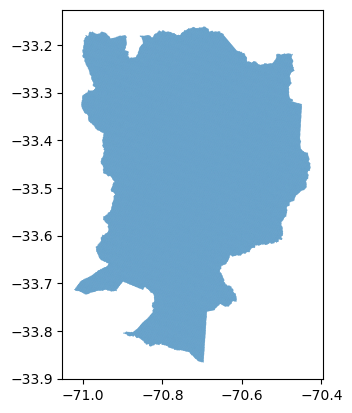

In [5]:
hex_gdf.plot()

## __Housing__

### __Housing__ - Load data

In [6]:
viv_nodes = gpd.read_file(count_pois_dir + 'casas_deptos_mzn.gpkg')
viv_nodes = viv_nodes[['osmid','total_viv','geometry']]
viv_nodes = viv_nodes.rename(columns={'total_viv':'viv_sum'})
# Show
print(viv_nodes.shape)
viv_nodes.head(2)

(214430, 3)


,osmid,viv_sum,geometry
0,14609420,20.126666,POINT (-70.75478 -33.51598)
1,266255164,21.028271,POINT (-70.79327 -33.52609)


### __Housing__ - Sum all viv by hexagon

In [7]:
viv_hexs = gpd.sjoin(viv_nodes, hex_gdf)
grouped_by = viv_hexs.groupby('hex_id').agg({'viv_sum':np.sum})
viv_gdf = grouped_by.reset_index().copy()
# Show
print(viv_gdf.shape)
print(f"NaNs in viv_sum: {viv_gdf.loc[viv_gdf.viv_sum.isna()].shape[0]}.")
viv_gdf.head(2)

(51097, 2)
NaNs in viv_sum: 0.


,hex_id,viv_sum
0,8ab2c0b00d67fff,1.896869e-07
1,8ab2c0b0426ffff,7.764535e-07


## __Social housing__

### __Social housing__ - Load data

In [8]:
socviv_nodes = gpd.read_file(count_pois_dir + 'viv_social.gpkg')
socviv_nodes = socviv_nodes.rename(columns={'housing':'viv_social_count'})
# Show
print(socviv_nodes.shape)
socviv_nodes.head(2)

(34639, 3)


,osmid,viv_social_count,geometry
0,14528355,0.662426,POINT (-70.69014 -33.45685)
1,14805060,1.897061,POINT (-70.58526 -33.47253)


### __Social housing__ - Calculate percentage of viv that belong to social housing by hex

In [9]:
# Sum social housing by hex
socviv_hex = gpd.sjoin(socviv_nodes, hex_gdf)
grouped_by = socviv_hex.groupby('hex_id').agg({'viv_social_count':np.sum})
socviv_gdf = grouped_by.reset_index().copy()

# Merge with previously calculated viv_hex
both_viv_gdf = pd.merge(viv_gdf,socviv_gdf,on='hex_id',how='outer')
# Fill NaNs in social viv with 0s and 
both_viv_gdf['viv_social_count'].fillna(0,inplace=True)
# Calculate pct of viv that are social viv
both_viv_gdf['pct_social_viv'] = (both_viv_gdf['viv_social_count']/both_viv_gdf['viv_sum'])*100

# Filter and format
both_viv_gdf = both_viv_gdf[['hex_id','viv_sum','pct_social_viv']]

# Drop pct_social_viv NaNs (0/0 or NaN/something)
print(f"NaNs in pct_social_viv: {both_viv_gdf.loc[both_viv_gdf.pct_social_viv.isna()].shape[0]}.")
both_viv_gdf.dropna(subset = ["pct_social_viv"], inplace=True)
print(f"NaNs in pct_social_viv: {both_viv_gdf.loc[both_viv_gdf.pct_social_viv.isna()].shape[0]}.")

# Show
print(both_viv_gdf.shape)
both_viv_gdf.head(2)

NaNs in pct_social_viv: 215.
NaNs in pct_social_viv: 0.
(50891, 3)


,hex_id,viv_sum,pct_social_viv
0,8ab2c0b00d67fff,1.896869e-07,0.0
1,8ab2c0b0426ffff,7.764535e-07,0.0


## __Hotels__

### __Hotels__ - Load usos de suelo data

In [10]:
# Load node data
uso_suelo_nodes = gpd.read_file(count_pois_dir + 'usos_de_suelo.gpkg')

# Calculate total area by node
all_uses = ['ADMIN','AGR','BBCC','BODEG','COM','CULT','DEPOR','EDUC','ERIAZO',
            'ESTAC','HABIT','HOTEL','INDUS','MIN','OFIC','OTROS','SALUD','TPTE']
uso_suelo_nodes['tot_area'] = uso_suelo_nodes[all_uses].sum(axis=1)

# Show
print(uso_suelo_nodes.shape)
uso_suelo_nodes.head(2)

(229965, 21)


,osmid,ADMIN,AGR,BBCC,BODEG,COM,CULT,DEPOR,EDUC,ERIAZO,...,HABIT,HOTEL,INDUS,MIN,OFIC,OTROS,SALUD,TPTE,geometry,tot_area
0,386139,0.0,0.0,0.520425,163.909199,769.964416,27.715437,0.0,13.781373,0.0,...,203.073595,14.213205,0.107459,0.0,887.353986,30.780062,0.199923,0.0,POINT (-70.64725 -33.44313),2111.619078
1,386140,0.0,0.0,0.000000,0.114390,0.532323,0.000000,0.0,0.000000,0.0,...,0.130597,0.000000,0.000000,0.0,0.618872,0.021155,0.000000,0.0,POINT (-70.64767 -33.44304),1.417338


### __Hotels__ - Calculate built percentage that belongs to hotels

In [11]:
# Sum all data (all usos de suelo) by hex
uso_suelo_hex = gpd.sjoin(uso_suelo_nodes, hex_gdf)
grouped_by = uso_suelo_hex.groupby('hex_id').agg({'HOTEL':np.sum,'tot_area':np.sum})
uso_suelo_gdf = grouped_by.reset_index().copy()

# Calculate percentage of total area that belongs to hotels by hex
uso_suelo_gdf['pct_hotel'] = (uso_suelo_gdf['HOTEL']/uso_suelo_gdf['tot_area'])*100

# Filter and format
hotel_gdf = uso_suelo_gdf[['hex_id','pct_hotel']]

# Drop pct_hotel NaNs (0/0 or NaN/something)
print(f"NaNs in pct_hotel: {hotel_gdf.loc[hotel_gdf.pct_hotel.isna()].shape[0]}.")
hotel_gdf.dropna(subset = ["pct_hotel"], inplace=True)
print(f"NaNs in pct_hotel: {hotel_gdf.loc[hotel_gdf.pct_hotel.isna()].shape[0]}.")

# Show
print(hotel_gdf.shape)
hotel_gdf.head(2)

NaNs in pct_hotel: 2715.
NaNs in pct_hotel: 0.
(56095, 2)


/tmp/ipykernel_74060/3601691173.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_gdf.dropna(subset = ["pct_hotel"], inplace=True)


,hex_id,pct_hotel
0,8ab2c0b0080ffff,0.0
1,8ab2c0b0081ffff,0.0


## __NDVI__

### __NDVI__ - Load data (Already processed to hexs)

In [12]:
ndvi_gdf = gpd.read_file(ndvi_dir + f'Santiago_ndvi_HexRes{res}_v0.geojson')
ndvi_gdf = ndvi_gdf[['hex_id','ndvi_mean']]
# Show
print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(64190, 2)


,hex_id,ndvi_mean
0,8ab2c5540647fff,0.135445
1,8ab2c546b0cffff,0.287743


## __Offices__

### __Offices__ - Load data

In [13]:
oficina_nodes = gpd.read_file(count_pois_dir + 'oficinas.gpkg')
oficina_nodes = oficina_nodes.rename(columns={'Oficinas':'oficinas_sum'})
# Show
print(oficina_nodes.shape)
oficina_nodes.head(2)

(229965, 3)


,osmid,oficinas_sum,geometry
0,386139,12.820194,POINT (-70.64725 -33.44313)
1,386140,0.008953,POINT (-70.64767 -33.44304)


### __Offices__ - Sum all offices by hexagon

In [14]:
oficina_hexs = gpd.sjoin(oficina_nodes, hex_gdf)
grouped_by = oficina_hexs.groupby('hex_id').agg({'oficinas_sum':np.sum})
oficina_gdf = grouped_by.reset_index().copy()
# Show
print(oficina_gdf.shape)
print(f"NaNs in oficinas_sum: {oficina_gdf.loc[oficina_gdf.oficinas_sum.isna()].shape[0]}.")
oficina_gdf.head(2)

(58810, 2)
NaNs in oficinas_sum: 0.


,hex_id,oficinas_sum
0,8ab2c0b0080ffff,0.182251
1,8ab2c0b0081ffff,0.104816


## Merge

In [15]:
print(f"Viv:{viv_gdf.shape}.")
print(f"Social viv:{socviv_gdf.shape}.")
print(f"Both viv:{both_viv_gdf.shape}.")
print(f"Hotels:{hotel_gdf.shape}.")
print(f"NDVI:{ndvi_gdf.shape}.")
print(f"Oficina:{oficina_gdf.shape}.")

Viv:(51097, 2).
Social viv:(8848, 2).
Both viv:(50891, 3).
Hotels:(56095, 2).
NDVI:(64190, 2).
Oficina:(58810, 2).


In [16]:
# Merge all areal data
hex_aereal = hex_gdf.merge(oficina_gdf, on='hex_id', how='outer')
hex_aereal = hex_aereal.merge(hotel_gdf,on='hex_id', how='outer')
hex_aereal = hex_aereal.merge(both_viv_gdf,on='hex_id', how='outer')
# Merge with ndvi is left because some hexs exist in ndvi, but not in hex_gdf from santiago aoi.
hex_aereal = hex_aereal.merge(ndvi_gdf,on='hex_id',how='right')
# Fill NaNs for _sum columns
hex_aereal[['oficinas_sum', 'viv_sum']] = hex_aereal[['oficinas_sum','viv_sum']].fillna(value=0)

# Show
print(hex_aereal.shape)
hex_aereal.head(2)

(64190, 7)


,hex_id,geometry,oficinas_sum,pct_hotel,viv_sum,pct_social_viv,ndvi_mean
0,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",1.186889,0.190803,51.747597,0.0,0.135445
1,8ab2c546b0cffff,"POLYGON ((-70.62472 -33.58049, -70.62535 -33.5...",0.000000,NaN,0.000000,NaN,0.287743


In [17]:
hex_aereal['res']=res

# Show
print(hex_aereal.shape)
hex_aereal.head(2)

(64190, 8)


,hex_id,geometry,oficinas_sum,pct_hotel,viv_sum,pct_social_viv,ndvi_mean,res
0,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",1.186889,0.190803,51.747597,0.0,0.135445,10
1,8ab2c546b0cffff,"POLYGON ((-70.62472 -33.58049, -70.62535 -33.5...",0.000000,NaN,0.000000,NaN,0.287743,10


## Save to local

In [18]:
if save:
    hex_aereal.to_file(grl_dir + f'hex_areal_res{res}.gpkg')
    print(f"Saved hex_areal_res{res}.gpkg to local.")

Saved hex_areal_res10.gpkg to local.
